# EMS Station Placement (Linear Programming) — Minimax *p-center* Model (PuLP)

## Problem statement
We consider a set of city districts \(I\). In each district \(i ∈ I\), there is a candidate location for building an Emergency Medical Service (EMS) station.

- Building cost in district \(i\) is \(f_i\).
- Total budget for building stations across the city is **50 million**.
- Logical constraint: if a station is built in district **2**, then a station **must not** be built in district **6**.
- Travel times (or distances) between districts are given by the provided graph.

**Goal:** choose where to build EMS stations so that the **maximum travel time** (worst-case response time) is **minimized**.

This is a minimax facility-location formulation (often called a **p-center** style model, but with the number of stations limited by budget).

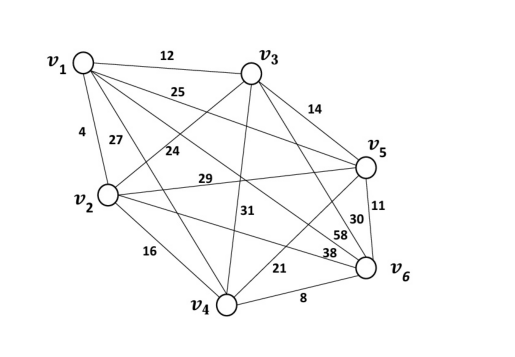

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("graph.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

## Data

### Build costs
Let \(f_i\) denote the build cost (in millions) of an EMS station in district \(i\).

$$
\mathbf{f} = [32,\ 20,\ 25,\ 30,\ 40,\ 29]
$$

<table>
  <thead>
    <tr>
      <th style="text-align:right;">District \(i\)</th>
      <th style="text-align:right;">1</th>
      <th style="text-align:right;">2</th>
      <th style="text-align:right;">3</th>
      <th style="text-align:right;">4</th>
      <th style="text-align:right;">5</th>
      <th style="text-align:right;">6</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="text-align:right;">Cost \(f_i\) (mil.)</td>
      <td style="text-align:right;">32</td>
      <td style="text-align:right;">20</td>
      <td style="text-align:right;">25</td>
      <td style="text-align:right;">30</td>
      <td style="text-align:right;">40</td>
      <td style="text-align:right;">29</td>
    </tr>
  </tbody>
</table>


<h3>Travel times / distances</h3>

<p>
Let \(d_{ij}\) be the travel time (or distance) from a station located in district \(i\) to district \(j\).
The matrix below shows all values \(d_{ij}\) taken from the given graph.
</p>

<table>
  <thead>
    <tr>
      <th style="text-align:right;">from \(\;i\;\) → \(\;j\;\)</th>
      <th style="text-align:right;">1</th>
      <th style="text-align:right;">2</th>
      <th style="text-align:right;">3</th>
      <th style="text-align:right;">4</th>
      <th style="text-align:right;">5</th>
      <th style="text-align:right;">6</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="text-align:right;"><b>1</b></td>
      <td style="text-align:right;">0</td>
      <td style="text-align:right;">4</td>
      <td style="text-align:right;">12</td>
      <td style="text-align:right;">27</td>
      <td style="text-align:right;">25</td>
      <td style="text-align:right;">58</td>
    </tr>
    <tr>
      <td style="text-align:right;"><b>2</b></td>
      <td style="text-align:right;">4</td>
      <td style="text-align:right;">0</td>
      <td style="text-align:right;">24</td>
      <td style="text-align:right;">16</td>
      <td style="text-align:right;">29</td>
      <td style="text-align:right;">38</td>
    </tr>
    <tr>
      <td style="text-align:right;"><b>3</b></td>
      <td style="text-align:right;">12</td>
      <td style="text-align:right;">24</td>
      <td style="text-align:right;">0</td>
      <td style="text-align:right;">31</td>
      <td style="text-align:right;">14</td>
      <td style="text-align:right;">30</td>
    </tr>
    <tr>
      <td style="text-align:right;"><b>4</b></td>
      <td style="text-align:right;">27</td>
      <td style="text-align:right;">16</td>
      <td style="text-align:right;">31</td>
      <td style="text-align:right;">0</td>
      <td style="text-align:right;">21</td>
      <td style="text-align:right;">8</td>
    </tr>
    <tr>
      <td style="text-align:right;"><b>5</b></td>
      <td style="text-align:right;">25</td>
      <td style="text-align:right;">29</td>
      <td style="text-align:right;">14</td>
      <td style="text-align:right;">21</td>
      <td style="text-align:right;">0</td>
      <td style="text-align:right;">11</td>
    </tr>
    <tr>
      <td style="text-align:right;"><b>6</b></td>
      <td style="text-align:right;">58</td>
      <td style="text-align:right;">38</td>
      <td style="text-align:right;">30</td>
      <td style="text-align:right;">8</td>
      <td style="text-align:right;">11</td>
      <td style="text-align:right;">0</td>
    </tr>
  </tbody>
</table>




### Budget
Total investment must not exceed **50 million**:

$$
\sum_{i \in I} f_i\,y_i \le 50
$$

### Mutual exclusion (logical constraint)
If a station is built in district 2, then district 6 must not have a station:

$$
y_2 + y_6 \le 1
$$

### Travel times / distances
Let \(d_{ij}\) be the travel time (or distance) from a station located in district \(i\) to district \(j\).  
The values \(d_{ij}\) are taken from the given graph and encoded in the distance matrix in the code.

## Mathematical model (minimax / p-center style)

### Sets and parameters
- \(I\): set of districts (candidate station locations)
- \(f_i\): build cost in district \(i\)
- \(d_{ij}\): travel time/distance from district \(i\) to district \(j\)
- Budget \(B = 50\)

### Decision variables
- \(y_i ∈ \{0,1\}\)  
  \(y_i = 1\) if we build a station in district \(i\), otherwise \(0\).

- \(x_{ij} ∈ \{0,1\}\)  
  \(x_{ij} = 1\) if district \(j\) is served by a station located in district \(i\), otherwise \(0\).

- \(h >= 0\)  
  The maximum (worst-case) travel time in the solution.

### Objective (minimax)
Minimize the worst-case travel time:

$$
\min\ h
$$

### Constraints

**(1) Minimax linking**  
For every assignment \(i → j\), the chosen travel time must not exceed \(h\):

$$
d_{ij}\,x_{ij} \le h \qquad \forall i \in I,\ \forall j \in I
$$

**(2) Service only from open stations**  
A district can serve others only if a station is built there:

$$
x_{ij} \le y_i \qquad \forall i \in I,\ \forall j \in I
$$

**(3) Every district must be served exactly once**

$$
\sum_{i \in I} x_{ij} = 1 \qquad \forall j \in I
$$

**(4) Mutual exclusion**

$$
y_2 + y_6 \le 1
$$

**(5) Budget constraint**

$$
\sum_{i \in I} f_i\,y_i \le 50
$$

In [2]:
# If PuLP is not installed, install it (uncomment if needed):
# !pip install pulp

import pulp
from typing import Dict, List, Tuple, Sequence, Any

In [3]:
# ----------------------------
# Input data (scalable setup)
# ----------------------------

# Build costs (million units)
cost: Dict[int, float] = {
    1: 32,
    2: 20,
    3: 25,
    4: 30,
    5: 40,
    6: 29,
}

budget: float = 50

# Distances / travel times dist[i][j]
dist: Dict[int, Dict[int, float]] = {
    1: {1: 0,  2: 4,  3: 12, 4: 27, 5: 25, 6: 58},
    2: {1: 4,  2: 0,  3: 24, 4: 16, 5: 29, 6: 38},
    3: {1: 12, 2: 24, 3: 0,  4: 31, 5: 14, 6: 30},
    4: {1: 27, 2: 16, 3: 31, 4: 0,  5: 21, 6: 8},
    5: {1: 25, 2: 29, 3: 14, 4: 21, 5: 0,  6: 11},
    6: {1: 58, 2: 38, 3: 30, 4: 8,  5: 11, 6: 0},
}

# Mutual exclusion pairs (can be extended easily)
mutually_exclusive: List[Tuple[int, int]] = [(2, 6)]

# Automatically create the set of districts from the cost keys
I: List[int] = sorted(cost.keys())

In [4]:
# ----------------------------
# Model build (same logic)
# ----------------------------

model = pulp.LpProblem("EMS_Station_Minimax_pCenter", pulp.LpMinimize)

# Decision variables
y = pulp.LpVariable.dicts("y", I, lowBound=0, upBound=1, cat=pulp.LpBinary)

x = pulp.LpVariable.dicts(
    "x",
    [(i, j) for i in I for j in I],
    lowBound=0,
    upBound=1,
    cat=pulp.LpBinary,
)

h = pulp.LpVariable("h", lowBound=0, cat=pulp.LpContinuous)

# Objective: minimize maximum travel time
model += h, "Minimize_max_travel_time"


# 1) Minimax linking constraints: dist[i][j] * x[i,j] <= h
for i in I:
    for j in I:
        model += dist[i][j] * x[(i, j)] <= h, f"MaxTime_{i}_{j}"


# 2) Can serve only if a station is built: x[i,j] <= y[i]
for i in I:
    for j in I:
        model += x[(i, j)] <= y[i], f"ServeOnlyIfOpen_{i}_{j}"


# 3) Each district j must be served by exactly one station: sum_i x[i,j] == 1
for j in I:
    model += pulp.lpSum(x[(i, j)] for i in I) == 1, f"Assign_{j}"


# 4) Mutual exclusion constraints: y[a] + y[b] <= 1
for a, b in mutually_exclusive:
    model += y[a] + y[b] <= 1, f"MutualExclusion_{a}_{b}"


# 5) Budget constraint: sum_i cost[i] * y[i] <= budget
model += pulp.lpSum(cost[i] * y[i] for i in I) <= budget, "Budget"

In [5]:
# ----------------------------
# Solve
# ----------------------------
model.solve(pulp.PULP_CBC_CMD(msg=0))   # use CBC explicitly
print("Status:", pulp.LpStatus[model.status])
print("h* =", pulp.value(h))

Status: Optimal
h* = 24.0


In [6]:
# ----------------------------
# Results (clean output) - SAFE
# ----------------------------

def val(v):
    """Return PuLP variable value; if None, return 0 (safe for printing)."""
    out = pulp.value(v)
    return 0 if out is None else out

open_stations = [i for i in I if val(y[i]) > 0.5]
total_cost = sum(cost[i] * val(y[i]) for i in I)

print("\nOpen stations (y[i]=1):", open_stations)
print("Total build cost:", total_cost, "(budget =", budget, ")")

print("\nAssignments (district j served by station i):")
assignments = {}
for j in I:
    chosen_i = None
    for i in I:
        if val(x[(i, j)]) > 0.5:
            chosen_i = i
            break
    assignments[j] = chosen_i
    if chosen_i is None:
        print(f"  District {j} -> (no assignment found)")
    else:
        print(f"  District {j} -> Station {chosen_i} (time {dist[chosen_i][j]})")


Open stations (y[i]=1): [2, 4]
Total build cost: 50.0 (budget = 50 )

Assignments (district j served by station i):
  District 1 -> Station 2 (time 4)
  District 2 -> Station 4 (time 16)
  District 3 -> Station 2 (time 24)
  District 4 -> Station 2 (time 16)
  District 5 -> Station 4 (time 21)
  District 6 -> Station 4 (time 8)


## Interpretation

- The model chooses a set of districts where EMS stations are built (variables \(y_i\)).
- Every district \(j\) must be assigned to exactly one built station \(i\) (variables \(x_{ij}\)).
- The objective minimizes \(h\), which is the **maximum travel time across all assigned districts**.

For this dataset (6 districts, given costs, budget 50, and the exclusion \(y_2 + y_6 <= 1\)), the optimal solution is:

- Build stations in districts **2 and 4**
- Optimal worst-case travel time:
\[
h^* = 24
\]

Reason (quick check by radius):
- With stations \(\{2,4\}\), the farthest district from its nearest station is district \(3\) with travel time
$$
\min(d_{2,3}, d_{4,3}) = \min(24,31) = 24.
$$
- Budget is exactly \(20 + 30 = 50\), so it is feasible.